<a href="https://colab.research.google.com/github/anuj0721/DataClub-ZoomCamp/blob/main/course-zoomcamp/04-evaluation/homework-4-starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import auc
from collections import Counter
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-01 17:33:49--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.004s  

2021-10-01 17:33:49 (49.6 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
categorical_vairables = ['home', 'marital', 'records', 'job', 'default']
numerical_vairables = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [10]:
auc_scores = {}
for c in numerical_vairables:
  if roc_auc_score(df_train.default, df_train[c]) >= 0.5:
    auc_scores[c] = roc_auc_score(df_train.default, df_train[c])
  else:
    auc_scores[c] = roc_auc_score(df_train.default, -df_train[c])

auc_scores

{'age': 0.5732933272499939,
 'amount': 0.5910773431595518,
 'assets': 0.6486042567122802,
 'debt': 0.5047829675783548,
 'expenses': 0.5009184217217011,
 'income': 0.682006666132633,
 'price': 0.5043329862114843,
 'seniority': 0.7093778624491943,
 'time': 0.5608662489595051}

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [11]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv = DictVectorizer(sparse = False)
train_dict = df_train[columns].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['default'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [13]:
y_pred_val = model.predict_proba(X_val)
roc_auc_score(df_val['default'], y_pred_val[:, 1]).round(3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [14]:
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
y_val = df_val['default']
y_pred = y_pred_val[:, 1].round(3)
for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)

  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)

  precisions.append(precision)
  recalls.append(recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

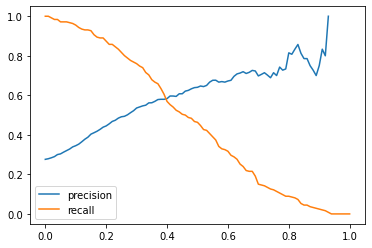

In [15]:
plt.plot(thresholds, precisions, label = 'precision')
plt.plot(thresholds, recalls, label = 'recall')
plt.legend()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


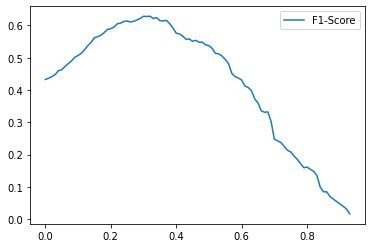

In [16]:
thresholds = np.linspace(0, 1, 101)
f1_scores = []

y_val = df_val['default']
y_pred = y_pred_val[:, 1].round(3)
for t in thresholds:
  actual_positive = (y_val == 1)
  actual_negative = (y_val == 0)

  predict_positive = (y_pred >= t)
  predict_negative = (y_pred < t)

  tp = (predict_positive & actual_positive).sum()
  tn = (predict_negative & actual_negative).sum()

  fp = (predict_positive & actual_negative).sum()
  fn = (predict_negative & actual_positive).sum()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)

  f1_score = 2*(precision*recall)/(precision+recall)
  f1_scores.append(f1_score)

plt.plot(thresholds, f1_scores, label = 'F1-Score')
plt.legend()

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]
  
  dv = DictVectorizer(sparse = False)
  train_dict = df_train[columns].to_dict(orient = 'records')
  X_train = dv.fit_transform(train_dict)

  val_dict = df_val[columns].to_dict(orient='records')
  X_val = dv.transform(val_dict)

  model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
  model.fit(X_train, df_train['default'])
  y_pred_val = model.predict_proba(X_val)
  score = roc_auc_score(df_val['default'], y_pred_val[:, 1]).round(3)

  auc_scores.append(score)

np.std(auc_scores)

0.013798550648528236

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [18]:
C = [0.01, 0.1, 1, 10]

C_scores = {}

for c in C:
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)

  auc_scores = []
  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    dv = DictVectorizer(sparse = False)
    train_dict = df_train[columns].to_dict(orient = 'records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[columns].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, df_train['default'])
    y_pred_val = model.predict_proba(X_val)
    score = roc_auc_score(df_val['default'], y_pred_val[:, 1]).round(3)

    auc_scores.append(score)
    dic = {}
    
    dic['mean'] = np.mean(auc_scores)
    dic['std'] = np.std(auc_scores)

    C_scores[c] = dic

C_scores

{0.01: {'mean': 0.8078000000000001, 'std': 0.011923086848631064},
 0.1: {'mean': 0.8126, 'std': 0.013763720427268164},
 1: {'mean': 0.8119999999999999, 'std': 0.013798550648528236},
 10: {'mean': 0.8141999999999999, 'std': 0.014661514246488965}}

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.